In [27]:
import gzip
import pickle
import matplotlib.pyplot as plt
import yaml
import io
import os
import numpy as np
np.seterr(all='warn')
import hist


from typing import Any, IO, Dict, List
import dctools
from dctools import plot as plotter
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy import stats as st

In [28]:
from cycler import cycler

def plotting(config, variable, channel, rebin=1, xlim=[], blind=False, era="someyear", checksyst=False):
    datasets:Dict = dict()
    color_cycle:List = []
    for name in config.groups:
        histograms = dict(
            filter(
                lambda _n: _n[0] in config.groups[name].processes,
                config.boosthist.items()
            )
        )
        p = dctools.datagroup(
            histograms = histograms,
            ptype      = config.groups[name].type,
            observable = variable,
            name       = name,
            xsections  = config.xsections,
            channel    = channel,
            luminosity = config.luminosity.value,
            rebin      = rebin
        )
        if 'gg' in p.name: continue
        datasets[p.name] = p
        if p.ptype == "signal":
            signal = p.name
            
        if hasattr(config.groups[name], "color") and len(p.to_boost().shape):
            color_cycle.append(config.groups[name].color)
            
    
    _plot_channel = plotter.add_process_axis(datasets)
    pred = _plot_channel.project('process', 'systematic', variable)[:hist.loc('data'),:,:]   
    data = _plot_channel[{'systematic':'nominal'}].project('process', variable)[hist.loc('data'),:]
    
    
    plt.figure(figsize=(6,7))
    ax, bx = plotter.mcplot(
        pred[{'systematic':'nominal'}].stack('process'),
        data=None if blind else data,
        syst=pred.stack('process'),
        colors = color_cycle
    )
    
    ymax = np.max([10000]+[c.get_height() for c in ax.containers[0] if ~np.isnan(c.get_height())])
    ymin = np.min([0.001]+[c.get_height() for c in ax.containers[0] if ~np.isnan(c.get_height())])
    
    ax.set_ylim(0.001, 1000*ymax)
    
    try:
        sig_ewk = _plot_channel[{'systematic':'nominal'}].project('process', variable)[hist.loc('VBSZZ2l2nu'),:]   
        sig_qcd = _plot_channel[{'systematic':'nominal'}].project('process', variable)[hist.loc('ZZ2l2nu'),:]   
        sig_ewk.plot(ax=ax, histtype='step', color='red')
        sig_qcd.plot(ax=ax, histtype='step', color='purple')
    except:
        pass
    bx.set_ylim([0.1, 1.9])
    if len(xlim) > 0:
        bx.set_xlim(xlim)
        
    ax.set_title(f"channel {channel}: {era}")
    ax.set_yscale('log')
    
    plt.savefig(f'plot-{channel}-{variable}-{era}.pdf')
    plt.savefig(f'plot-{channel}-{variable}-{era}.png')
    
    
    if checksyst:
        pred = _plot_channel.project('process','systematic', variable)[:hist.loc('data'),:,:]
        data = _plot_channel[{'systematic':'nominal'}].project('process',variable)[hist.loc('data'),:] 
        plotter.check_systematic(
            pred[{'systematic':'nominal'}].stack('process'),
            syst=pred.stack('process'),
            plot_file_name=f'check-sys-{channel}-{era}', 
            xrange=xlim
        )
    return _plot_channel, datasets

In [29]:
def systematic_check(config, variable, channel, rebin=1, xlim=[], blind=False, era="someyear") -> None:
    datasets:Dict = dict()
    color_cycle:List = []
    h_pred_tot = []
    for name in config.groups:
        histograms = dict(
            filter(
                lambda _n: _n[0] in config.groups[name].processes,
                config.boosthist.items()
            )
        )
        p = dctools.datagroup(
            histograms = histograms,
            ptype      = config.groups[name].type,
            observable = variable,
            name       = name,
            xsections  = config.xsections,
            channel    = channel,
            luminosity = config.luminosity.value,
            rebin      = rebin
        )
        if p.name == 'ggVV': continue
        datasets[p.name] = p
        if p.ptype == "signal":
            signal = p.name
            
        plt.figure(figsize=(5,5))
        plt.title(f"{channel} : {p.name}")
        if p.name != 'data':
            h_pred_tot.append(p.to_boost())
        try:
            p.to_boost()[{'systematic':'nominal'}].plot(label='nominal', color='black')
            p.to_boost()[{'systematic':'pileup_weightUp'}].plot(label='Up', color='red')
            p.to_boost()[{'systematic':'pileup_weightDown'}].plot(label='Down', color='blue')
            plt.legend()
            plt.yscale("log")
        except:
            print(f"{channel} : {p.name} : missing")
            pass
        plt.show()
        
    plt.figure(figsize=(5,5))
    plt.title(f"{channel} : {p.name} : total")
    print(" nominals  ------- ")
    print(np.round([hh[{'systematic':'nominal'}].values(0) for hh in h_pred_tot],5))
    print(" Ups       ------- ")
    print(np.round([hh[{'systematic':'JERUp'}].values(0) for hh in h_pred_tot],5))
    print(" Downs     ------- ")
    print(np.round([hh[{'systematic':'JERDown'}].values(0) for hh in h_pred_tot],5))
    
    print(" hnominals  ------- ")
    print(np.round([hh[{'systematic':'nominal'}].variances(0) for hh in h_pred_tot],5))
    print(" hUps       ------- ")
    print(np.round([hh[{'systematic':'JERUp'}].variances(0) for hh in h_pred_tot],5))
    print(" hDowns     ------- ")
    print(np.round([hh[{'systematic':'JERDown'}].variances(0) for hh in h_pred_tot],5))
    print(" Total     ------- ")
    h_tot = sum(h_pred_tot)
    print(" nom  ", np.round(h_tot[{'systematic':'nominal'}].values(0),5))
    print(" up   ", np.round(h_tot[{'systematic':'pileup_weightUp'}].values(0),5))
    print(" down ", np.round(h_tot[{'systematic':'pileup_weightDown'}].values(0),5))
    print(" ----------------- ")                    
    h_tot[{'systematic':'nominal'}].plot(label='nominal', color='black')
    h_tot[{'systematic':'pileup_weightUp'}].plot(label='Up', color='red')
    h_tot[{'systematic':'pileup_weightDown'}].plot(label='Down', color='blue')
    plt.legend()
    plt.ylim([0.001, 2e4])
    plt.yscale("log")
    plt.show()

photon_VBS
vbs-DY
vbs-TT
vbs-NR
vbs-SR
photon_VBS_2
dict_items([('GJets', <dctools.datagroup object at 0x7fd6885c8850>), ('data', <dctools.datagroup object at 0x7fd68822d850>)])
<class 'dctools.datagroup'>
(33, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd688331340>), ('data', <dctools.datagroup object at 0x7fd689695610>)])
<class 'dctools.datagroup'>
(33, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd689629dc0>), ('data', <dctools.datagroup object at 0x7fd688e563a0>)])
<class 'dctools.datagroup'>
(33, 5)
monika i am here
<class 'dctools.datagroup'>
(1, 5)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd688cf93a0>), ('data', <dctools.datagroup object at 0x7fd688cf97c0>)])
<class 'dctools.d

/opt/conda/lib/python3.8/site-packages/matplotlib/patches.py:737: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/opt/conda/lib/python3.8/site-packages/matplotlib/transforms.py:2047: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty
/opt/conda/lib/python3.8/site-packages/matplotlib/patches.py:737: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/opt/conda/lib/python3.8/site-packages/matplotlib/transforms.py:2047: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


dict_items([('GJets', <dctools.datagroup object at 0x7fd689158be0>), ('data', <dctools.datagroup object at 0x7fd6885d1b50>)])
<class 'dctools.datagroup'>
(33, 25)
monika i am here
<class 'dctools.datagroup'>
(1, 25)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd68828ee20>), ('data', <dctools.datagroup object at 0x7fd6894c05e0>)])
<class 'dctools.datagroup'>
(33, 25)
monika i am here
<class 'dctools.datagroup'>
(1, 25)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd688fed0a0>), ('data', <dctools.datagroup object at 0x7fd689d0f3d0>)])
<class 'dctools.datagroup'>
(33, 25)
monika i am here
<class 'dctools.datagroup'>
(1, 25)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd68932c580>), ('data', <dctools.datagroup object at 0x7fd688af1280>)])
<class 'dctools.datagroup'>
(33, 25)
monika i am here
<class 'dctoo

/opt/conda/lib/python3.8/site-packages/matplotlib/patches.py:737: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/opt/conda/lib/python3.8/site-packages/matplotlib/transforms.py:2047: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty
/opt/conda/lib/python3.8/site-packages/matplotlib/patches.py:737: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/opt/conda/lib/python3.8/site-packages/matplotlib/transforms.py:2047: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


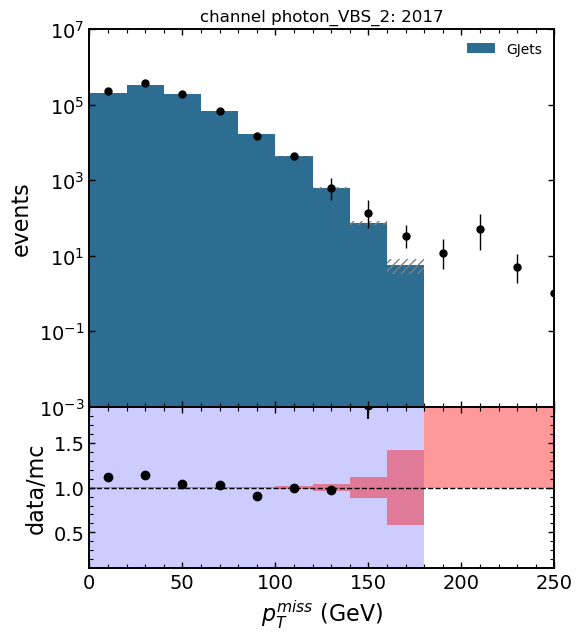

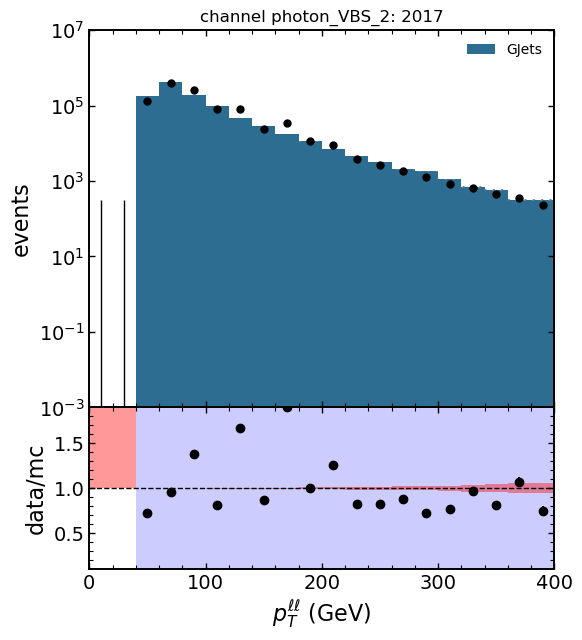

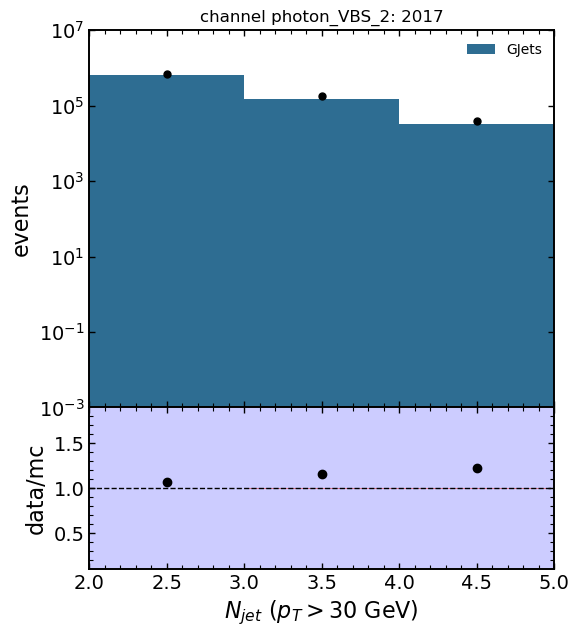

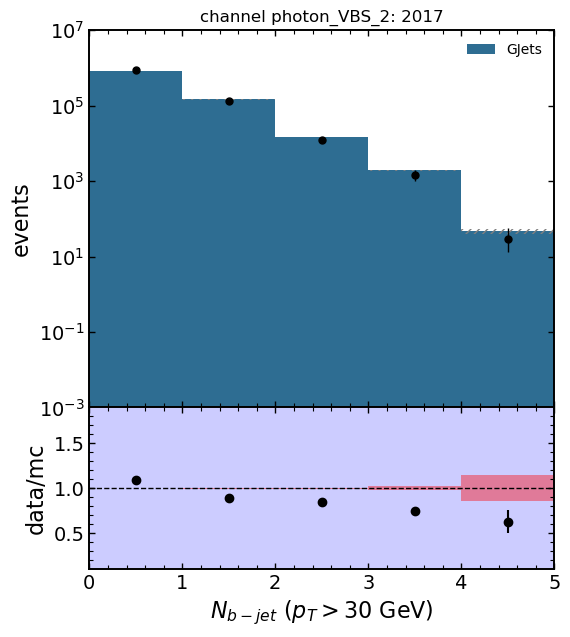

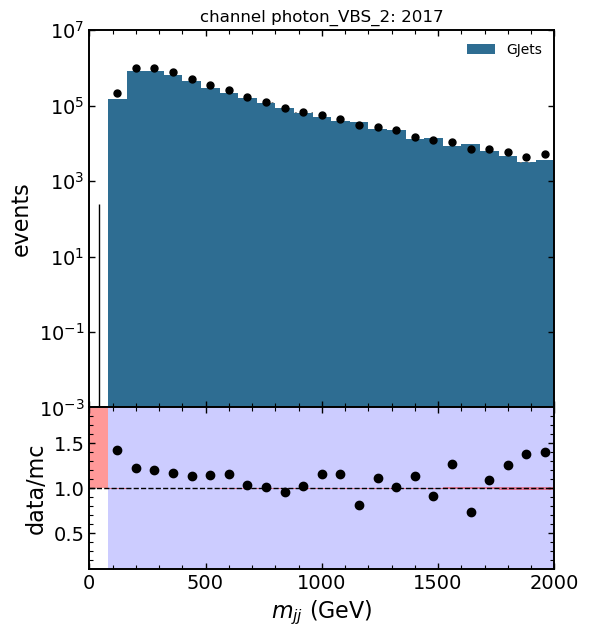

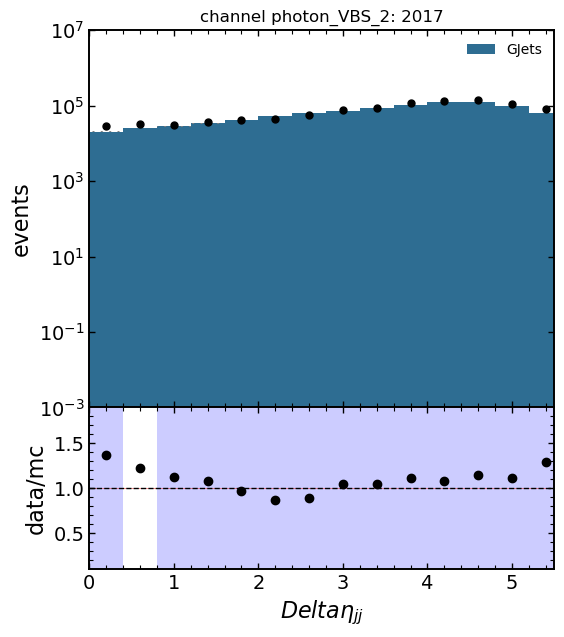

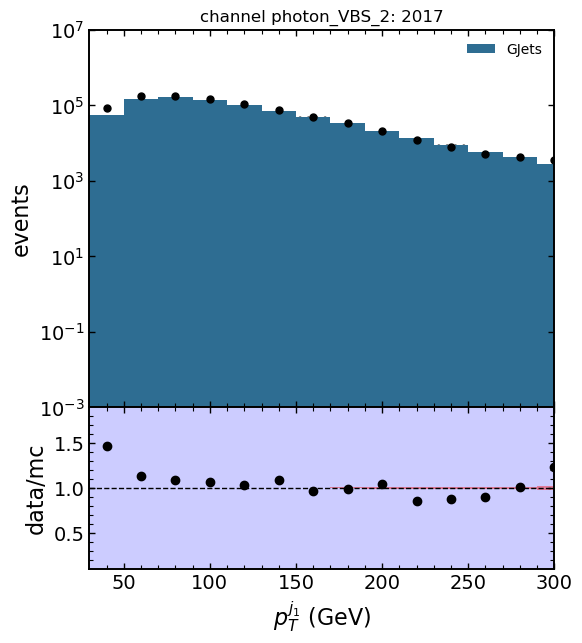

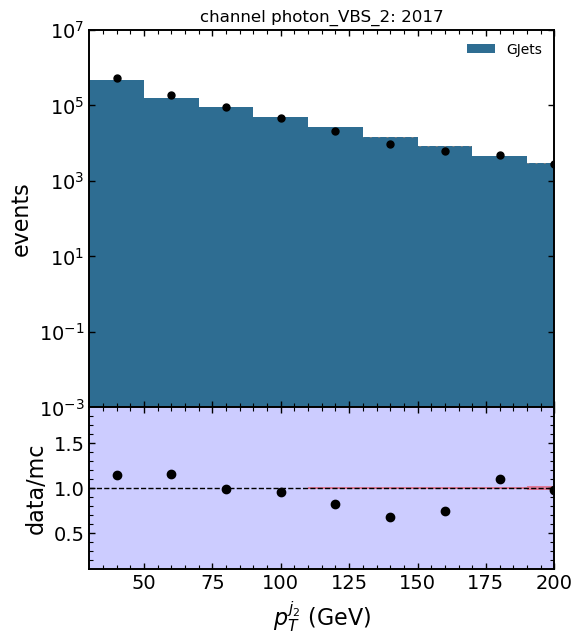

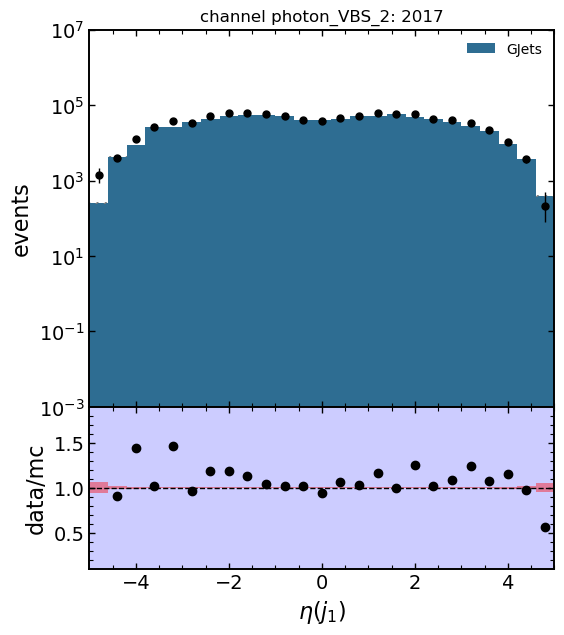

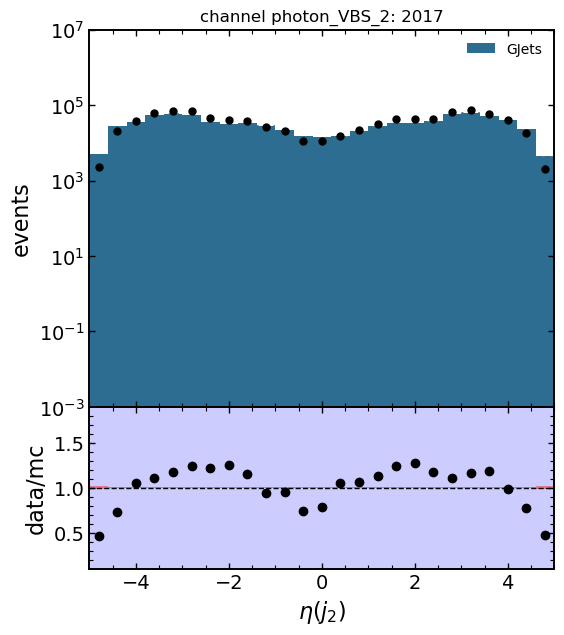

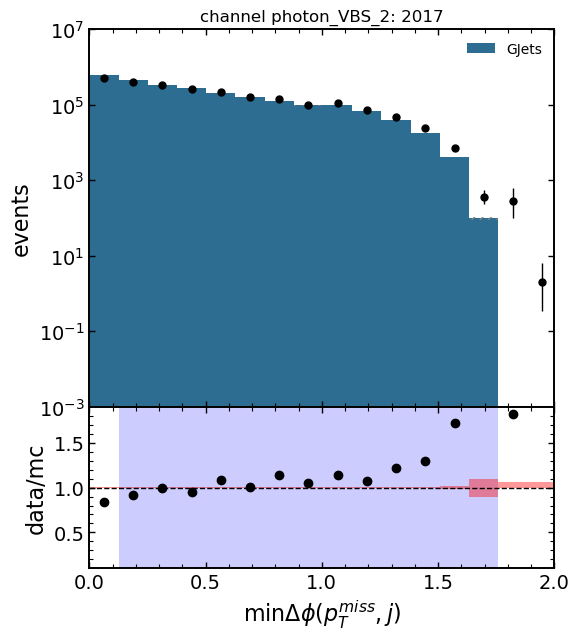

In [42]:
config_2017    = dctools.read_config("config/nput_UL_2017-PhotonCR.yaml")
for channel in config_2017.plotting:
    ch_cfg = config_2017.plotting[channel]
    print(channel)
    if channel not in ['photon_VBS_2']: continue
    for vname in ch_cfg:
        #if 'met_pt'  in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2017, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2017"
        )

photon_VBS
dict_items([('GJets', <dctools.datagroup object at 0x7fd689103190>), ('data', <dctools.datagroup object at 0x7fd6894de6a0>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd6899705e0>), ('data', <dctools.datagroup object at 0x7fd6874040a0>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd689f07850>), ('data', <dctools.datagroup object at 0x7fd6895341c0>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd689621fd0>), ('data', <dctools.datagroup object at 0x7fd688b637c0>)])
<class 'dctools.datagroup'>
(35, 5)
monika i am here
<cl

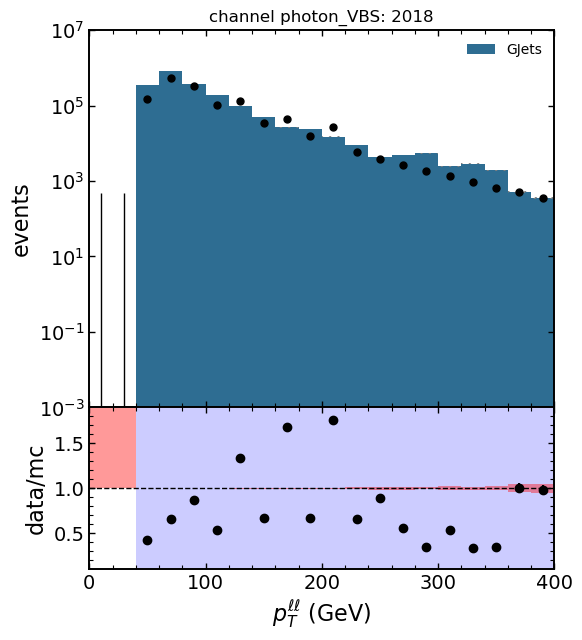

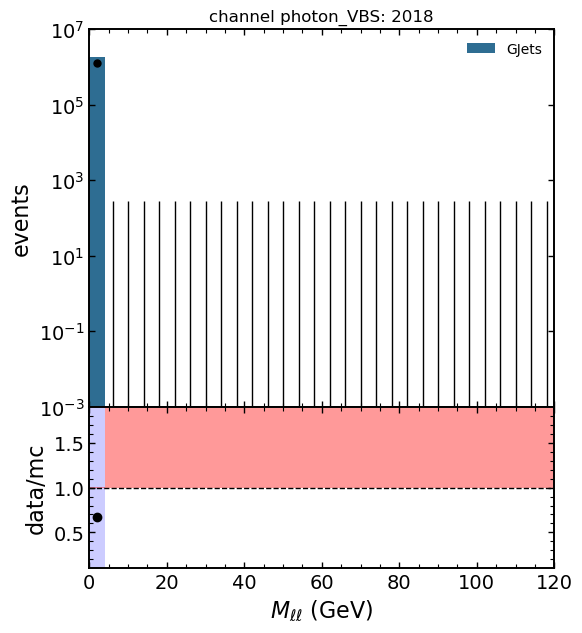

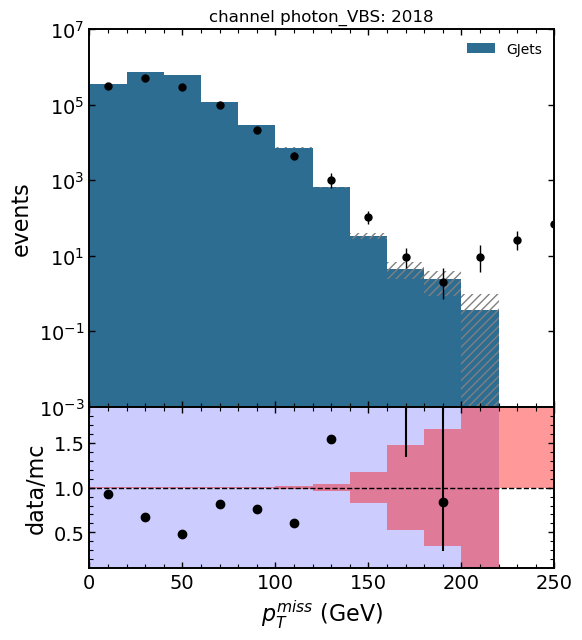

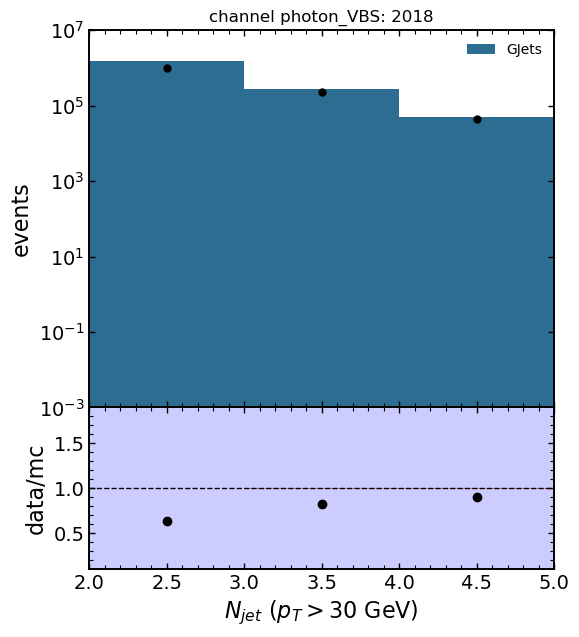

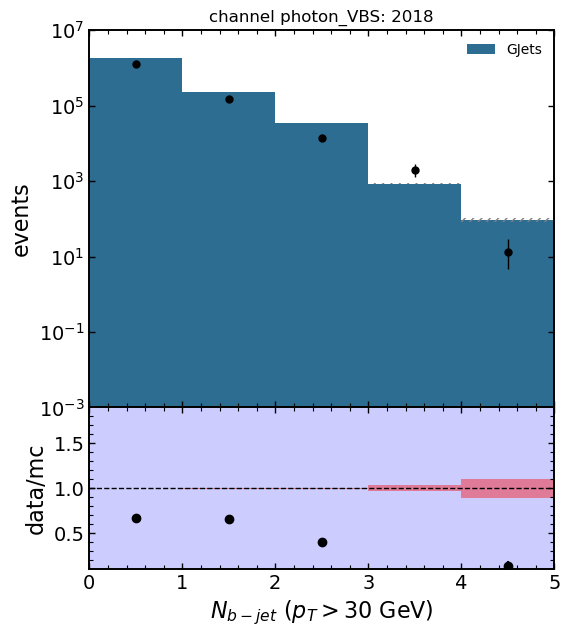

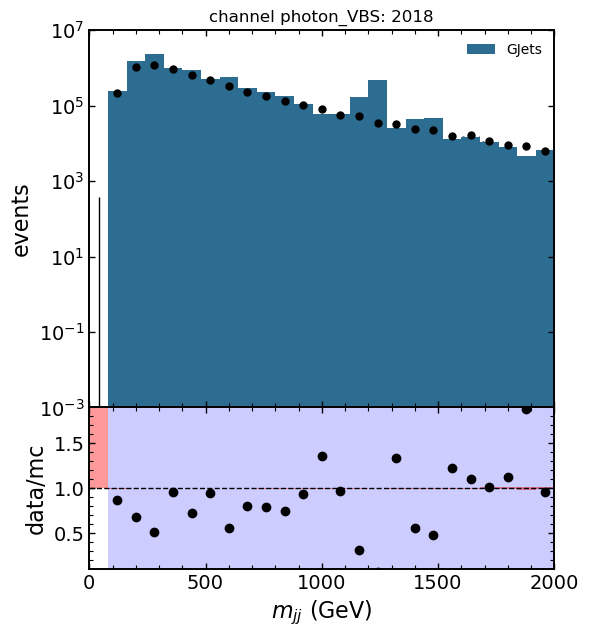

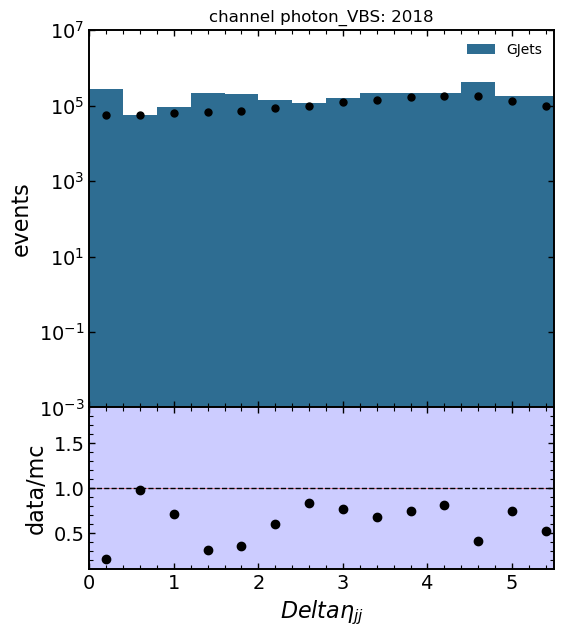

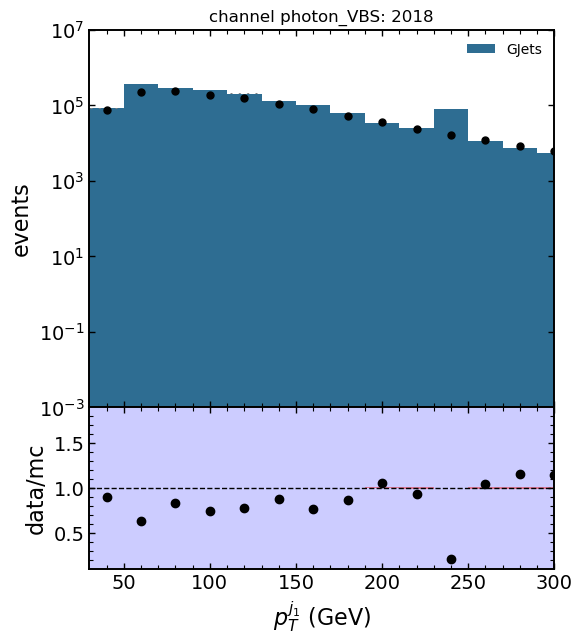

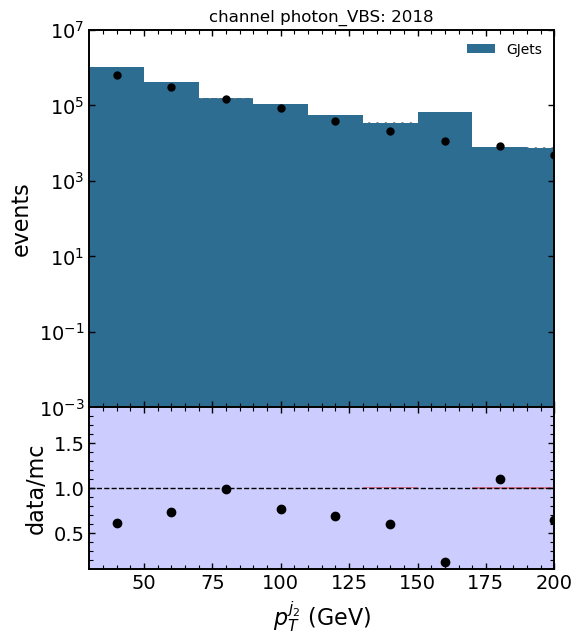

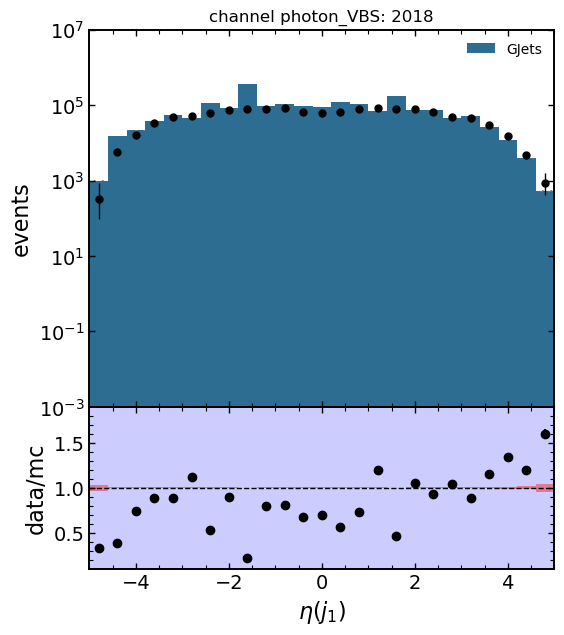

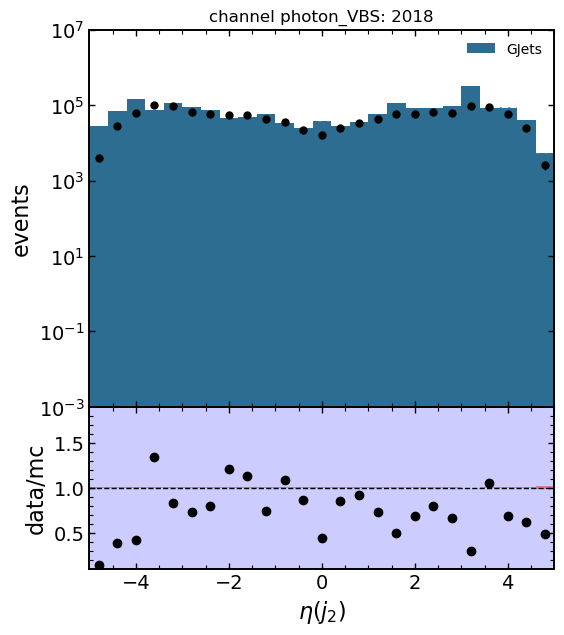

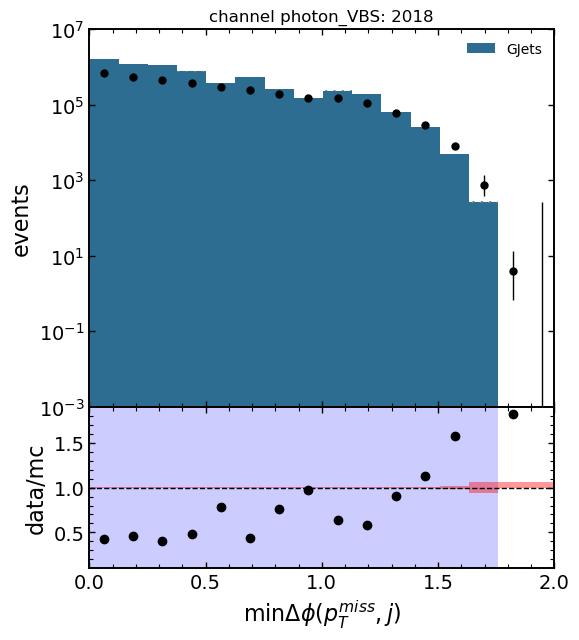

In [48]:
config_2018    = dctools.read_config("config/input_UL_2018-PhotonCR.yaml")
for channel in config_2018.plotting:
    ch_cfg = config_2018.plotting[channel]
    print(channel)
    if channel not in ['photon_VBS']: continue
    for vname in ch_cfg:
        #if 'met_pt' not in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2018, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            blind=v_cfg.blind,
            era="2018"
        )

photon_VBS
dict_items([('GJets', <dctools.datagroup object at 0x7fd689918a60>), ('data', <dctools.datagroup object at 0x7fd688576dc0>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd688b63fa0>), ('data', <dctools.datagroup object at 0x7fd689d56fd0>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fda70109520>), ('data', <dctools.datagroup object at 0x7fd68833dee0>)])
<class 'dctools.datagroup'>
(35, 5)
monika i am here
<class 'dctools.datagroup'>
(1, 5)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd6894af850>), ('data', <dctools.datagroup object at 0x7fd688b5faf0>)])
<class 'dctools.datagroup'>
(35, 5)
monika i am here
<clas

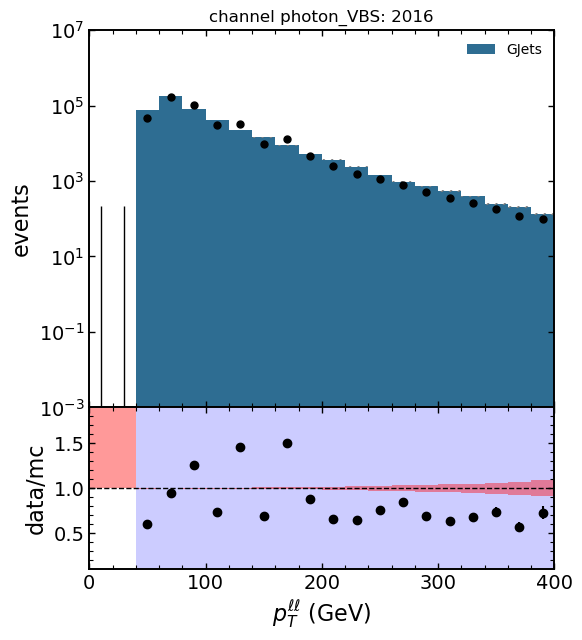

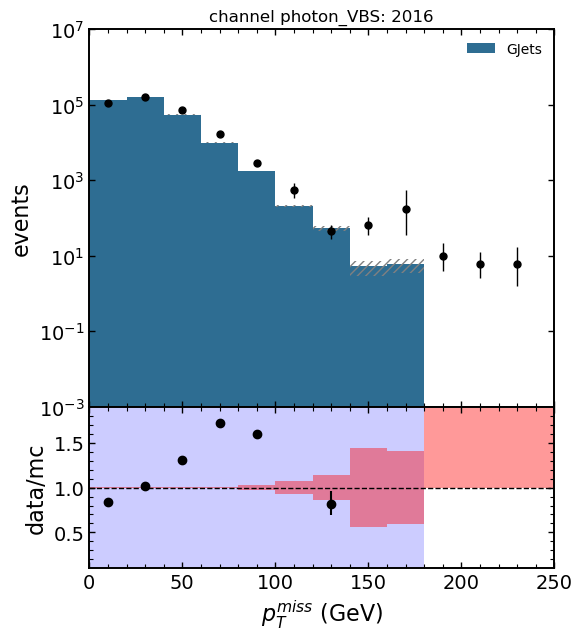

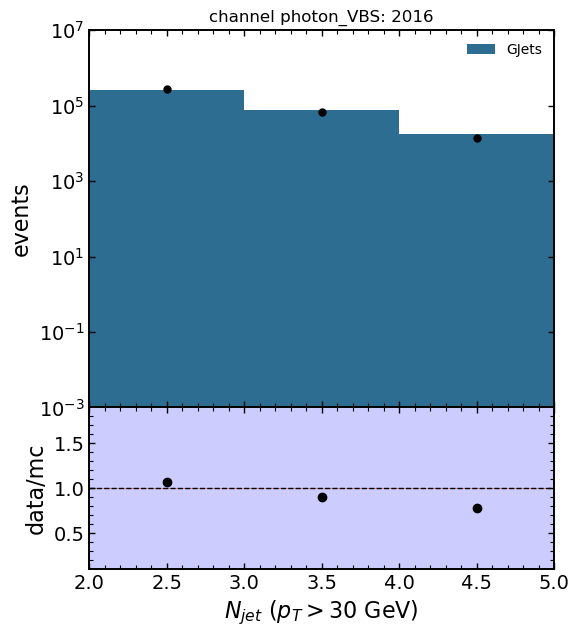

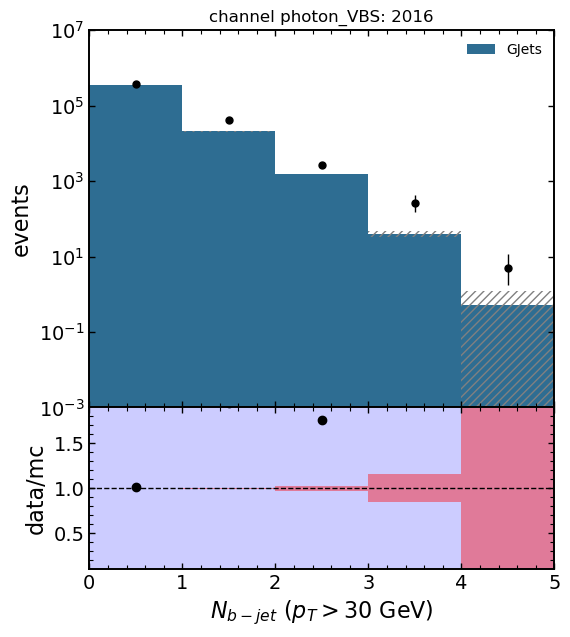

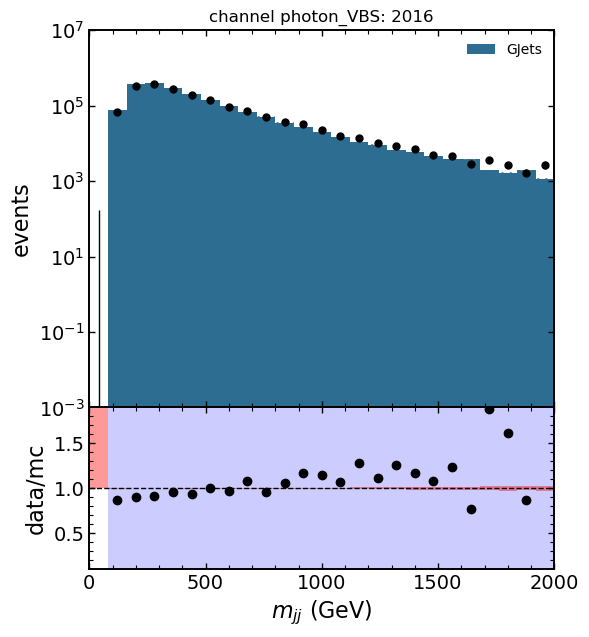

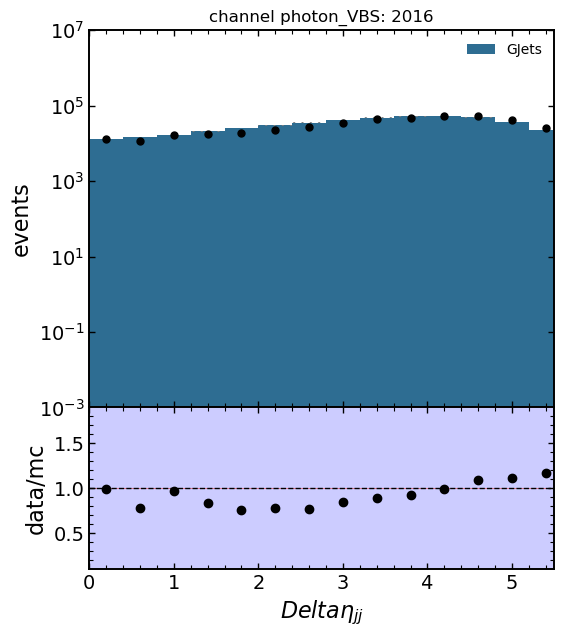

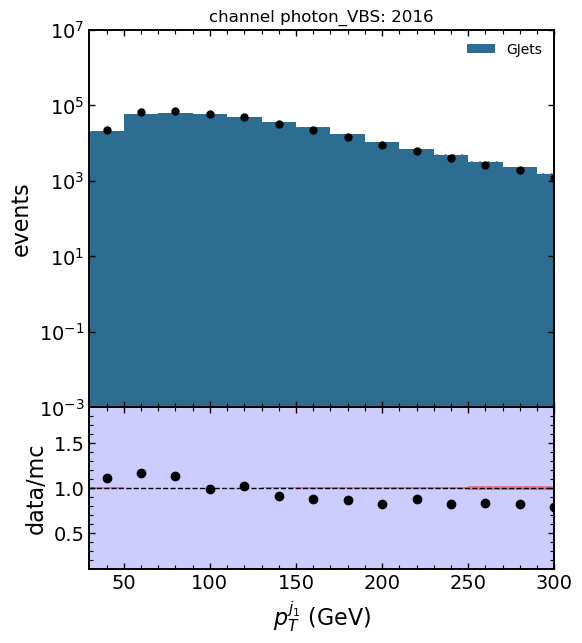

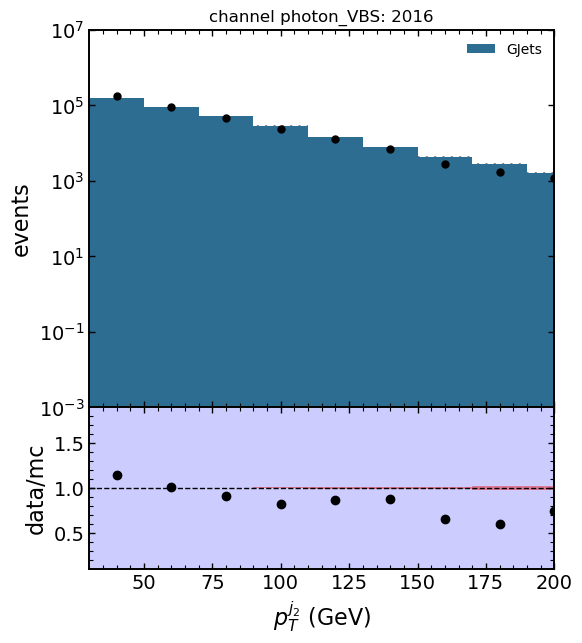

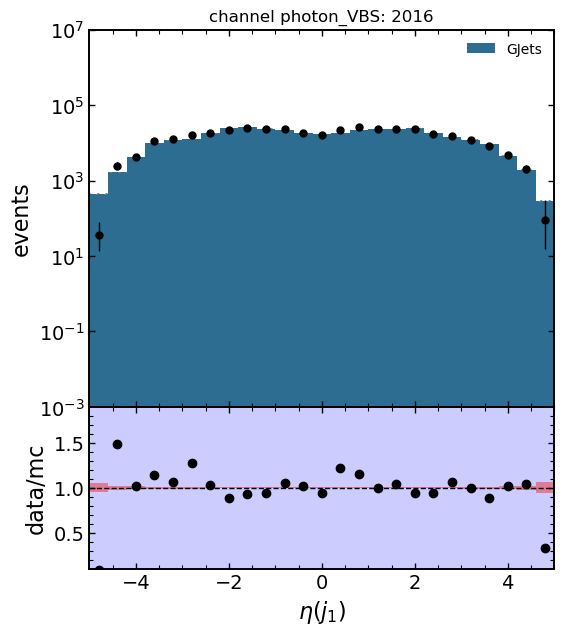

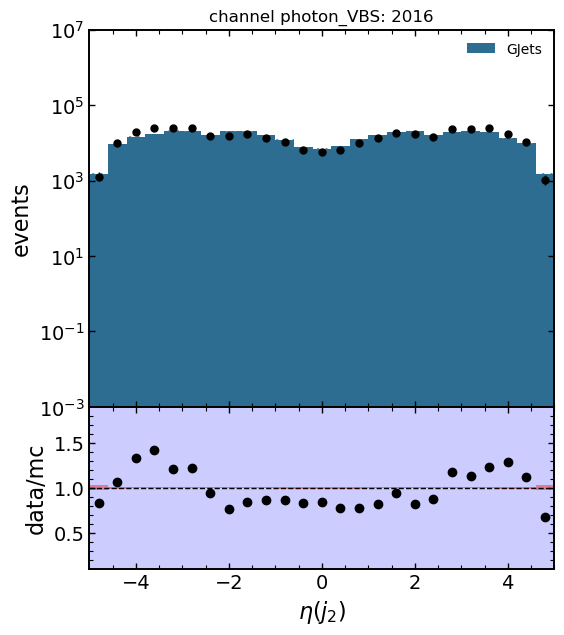

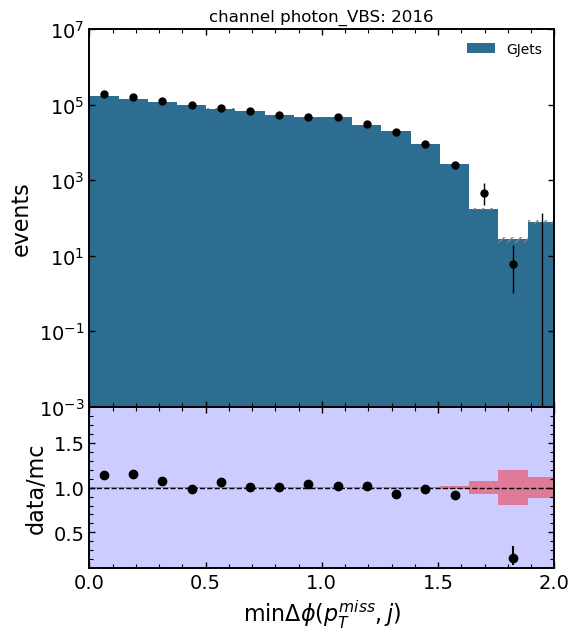

In [50]:
config_2016    = dctools.read_config("config/nput_UL_2016-PhotonCR.yaml")
for channel in config_2016.plotting:
    ch_cfg = config_2016.plotting[channel]
    print(channel)
    if channel not in ['photon_VBS']: continue
    for vname in ch_cfg:
        #if 'met_pt'  in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2016, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2016"
        )

photon_VBS
vbs-DY
vbs-TT
vbs-NR
vbs-SR
photon_VBS_2
dict_items([('GJets', <dctools.datagroup object at 0x7fd68959c070>), ('data', <dctools.datagroup object at 0x7fd688402520>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd689ac6e80>), ('data', <dctools.datagroup object at 0x7fd6885e5c70>)])
<class 'dctools.datagroup'>
(35, 30)
monika i am here
<class 'dctools.datagroup'>
(1, 30)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd687071f70>), ('data', <dctools.datagroup object at 0x7fd688081610>)])
<class 'dctools.datagroup'>
(35, 5)
monika i am here
<class 'dctools.datagroup'>
(1, 5)
monika i am here
monika dict_keys(['GJets', 'data'])
dict_items([('GJets', <dctools.datagroup object at 0x7fd689720340>), ('data', <dctools.datagroup object at 0x7fd689720eb0>)])
<class 'dctools.d

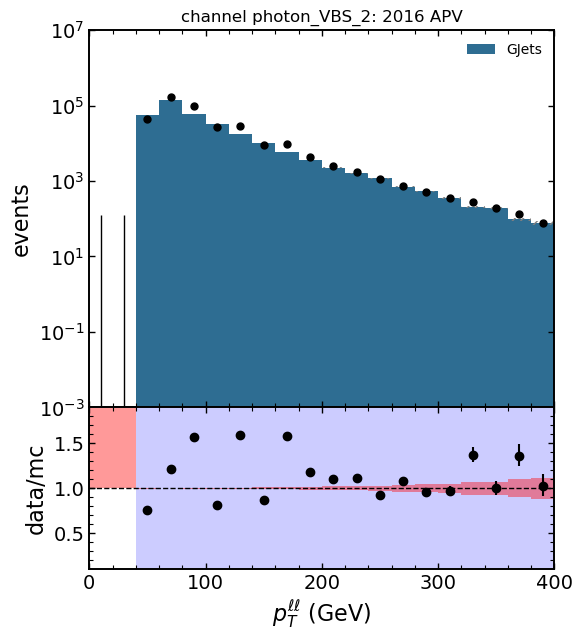

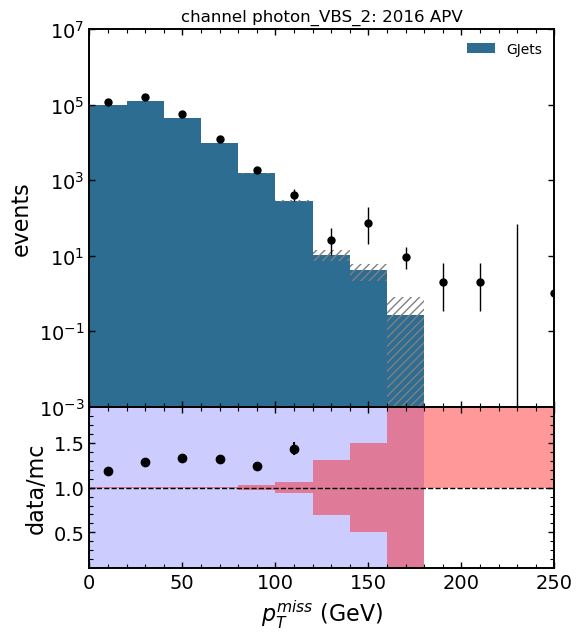

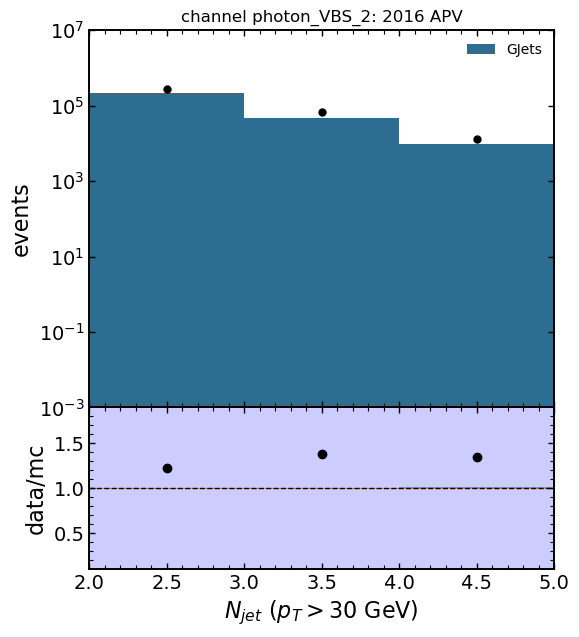

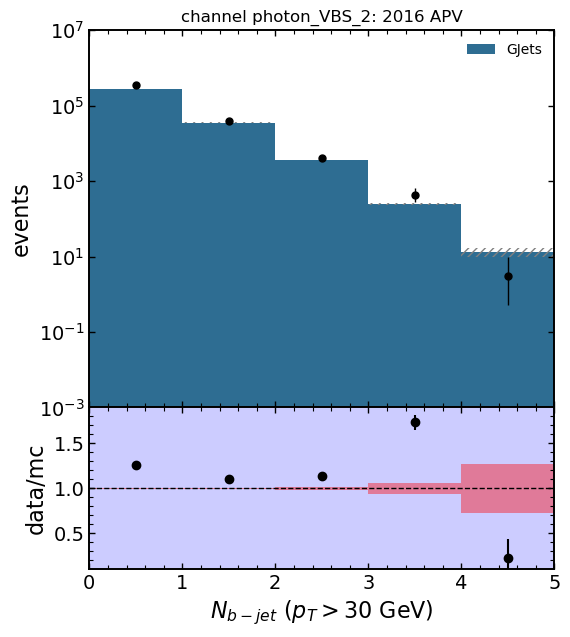

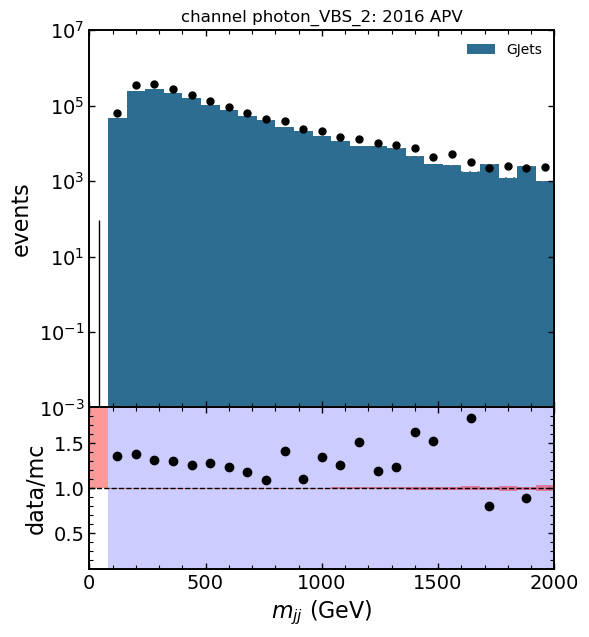

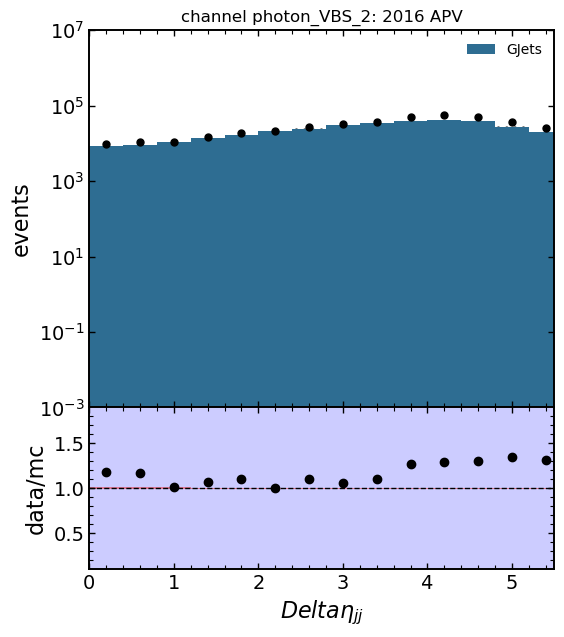

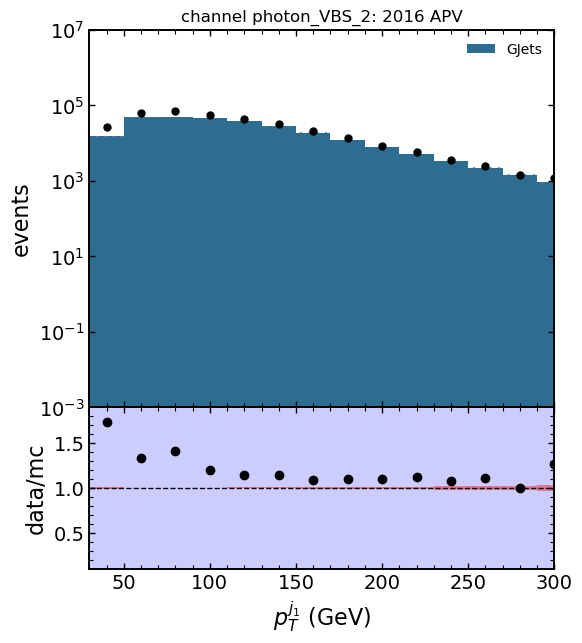

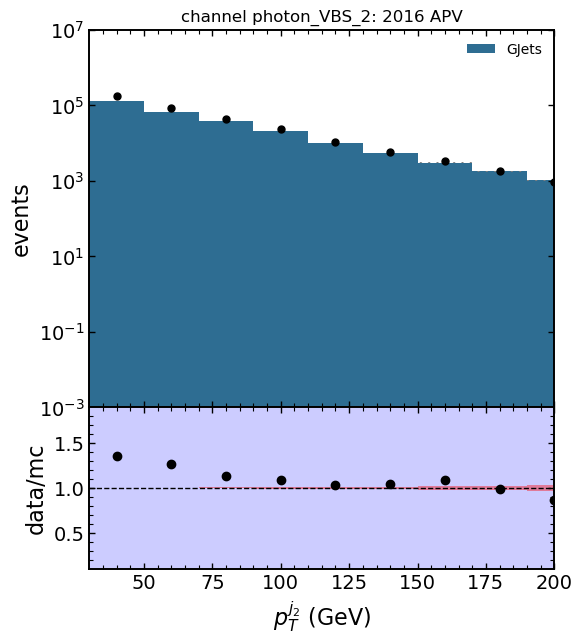

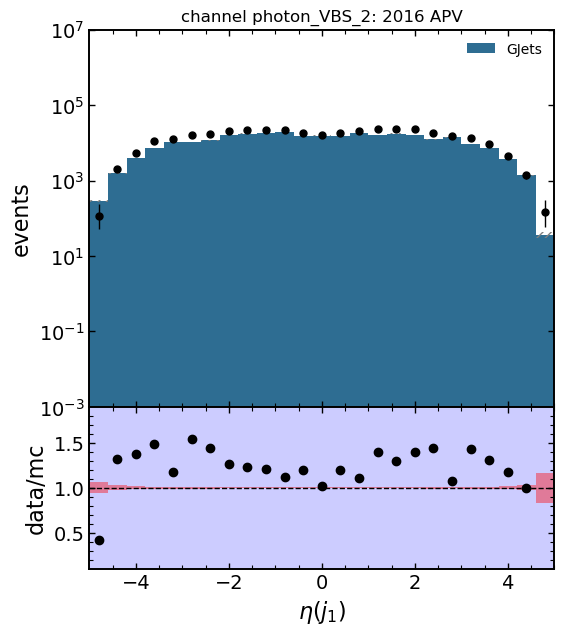

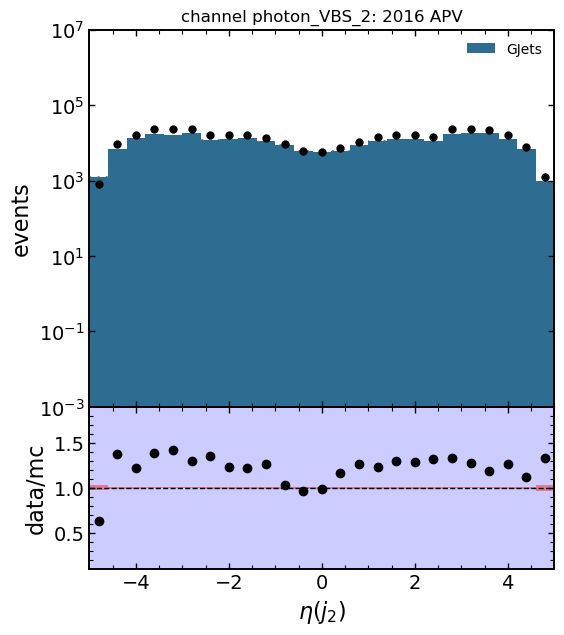

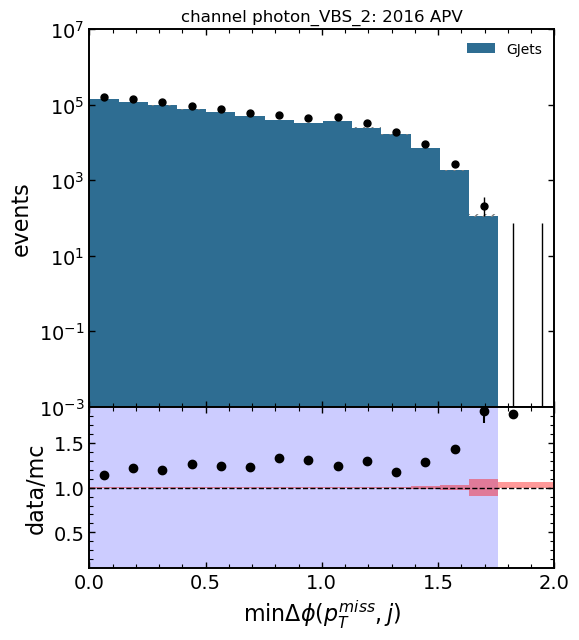

In [53]:
config_2016    = dctools.read_config("config/nput_UL_2016APV-PhotonCR.yaml")
for channel in config_2016.plotting:
    ch_cfg = config_2016.plotting[channel]
    print(channel)
    if channel not in ['photon_VBS_2']: continue
    for vname in ch_cfg:
        #if 'met_pt'  in vname: continue
        v_cfg = ch_cfg[vname]
        plotting(
            config_2016, vname, channel, 
            rebin=v_cfg.rebin, 
            xlim=v_cfg.range, 
            #blind=v_cfg.blind,
            era="2016 APV"
        )